In [1]:
import os
os.environ["PYTHONWARNINGS"] = "ignore"
os.chdir("..")
import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils.completer import complete_by_mean_col, complete_by_mean_col_v2
from utils.completer import complete_by_multi, complete_by_multi_v2
from utils.completer import complete_by_similar_row, complete_by_similar_row_v2
from utils.generator import gen_complete_random
from utils.data import create_adult_dataset

### Disparate Impact Remover  
[example notebook](https://github.com/Trusted-AI/AIF360/blob/master/examples/demo_disparate_impact_remover.ipynb)

In [2]:
from aif360.datasets import BinaryLabelDataset, StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import DisparateImpactRemover

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [4]:
data = create_adult_dataset()
print(data.X.shape)
print(data.X.isnull().sum().sum())

(32561, 10)
0


In [5]:
data_incomplete = gen_complete_random(data, random_ratio=0.2)
print(data_incomplete.X.isnull().sum())

gen_complete_random: 58244 NaN values have been inserted
age               6465
workclass         6456
education         6451
education-num     6455
marital-status    6437
occupation        6507
relationship      6539
race              6430
hours-per-week    6504
sex                  0
dtype: int64


In [6]:
data_complete = complete_by_mean_col(data_incomplete)
print(data_complete.X.isnull().sum())

age               0
workclass         0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
hours-per-week    0
sex               0
dtype: int64


In [7]:
from sklearn.model_selection import train_test_split
tmp_df = pd.concat([data_complete.X, pd.DataFrame(data_complete.y, columns=["_TARGET_"])], axis=1).copy()
tmp_df['sex'] = tmp_df['sex'].apply(lambda x : 0.0 if x == ' Female' else 1.0) # necessary for aif360 to understand
tmp_df_train, tmp_df_test = train_test_split(tmp_df, test_size=0.3, shuffle=True)
data_imputed_train = StandardDataset(df=tmp_df_train, label_name="_TARGET_", favorable_classes=lambda x: x > 0,
                                     protected_attribute_names=['sex'], privileged_classes=[[1.0]],
                                     features_to_keep=data_complete.X.columns.tolist(),
                                     instance_weights_name=None, features_to_drop=[],
                                     custom_preprocessing=None, categorical_features=data_complete.categorical_features)
data_imputed_test = StandardDataset(df=tmp_df_test, label_name="_TARGET_", favorable_classes=lambda x: x > 0,
                                    protected_attribute_names=['sex'], privileged_classes=[[1.0]],
                                    features_to_keep=data_complete.X.columns.tolist(),
                                    instance_weights_name=None, features_to_drop=[],
                                    custom_preprocessing=None, categorical_features=data_complete.categorical_features)

In [8]:
# scaler = MinMaxScaler(copy=False)
scaler = StandardScaler()
data_imputed_train.features = scaler.fit_transform(data_imputed_train.features)
data_imputed_test.features = scaler.transform(data_imputed_test.features)

In [9]:
# prepare for original data
tmp_df = pd.concat([data.X, pd.DataFrame(data.y, columns=["_TARGET_"])], axis=1).copy()
tmp_df['sex'] = tmp_df['sex'].apply(lambda x : 0.0 if x == ' Female' else 1.0) # necessary for aif360 to understand
tmp_df_train, tmp_df_test = train_test_split(tmp_df, test_size=0.3, shuffle=True)
data_orig_train = StandardDataset(df=tmp_df_train, label_name="_TARGET_", favorable_classes=lambda x: x > 0,
                                  protected_attribute_names=['sex'], privileged_classes=[[1.0]],
                                  features_to_keep=data_complete.X.columns.tolist(),
                                  instance_weights_name=None, features_to_drop=[],
                                  custom_preprocessing=None, categorical_features=data_complete.categorical_features)
data_orig_test = StandardDataset(df=tmp_df_test, label_name="_TARGET_", favorable_classes=lambda x: x > 0,
                                 protected_attribute_names=['sex'], privileged_classes=[[1.0]],
                                 features_to_keep=data_complete.X.columns.tolist(),
                                 instance_weights_name=None, features_to_drop=[],
                                 custom_preprocessing=None, categorical_features=data_complete.categorical_features)

In [10]:
data_orig_train.features = scaler.fit_transform(data_orig_train.features)
data_orig_test.features = scaler.transform(data_orig_test.features)

In [11]:
def run(train, test):
    index = train.feature_names.index('sex')
    DIs = []
    for level in tqdm(np.linspace(0., 1., 11)):
        di = DisparateImpactRemover(repair_level=level)
        train_repd = di.fit_transform(train)
        test_repd = di.fit_transform(test)
    
        X_tr = np.delete(train_repd.features, index, axis=1)
        X_te = np.delete(test_repd.features, index, axis=1)
        y_tr = train_repd.labels.ravel()
    
        lmod = LogisticRegression(class_weight='balanced', solver='liblinear')
        lmod.fit(X_tr, y_tr)
    
        test_repd_pred = test_repd.copy()
        test_repd_pred.labels = lmod.predict(X_te)

        p = [{'sex': 1}]
        u = [{'sex': 0}]
        cm = BinaryLabelDatasetMetric(test_repd_pred, privileged_groups=p, unprivileged_groups=u)
        DIs.append(cm.disparate_impact())
    return DIs

In [12]:
DIs1 = run(data_imputed_train, data_imputed_test)

100%|██████████| 11/11 [01:08<00:00,  6.22s/it]


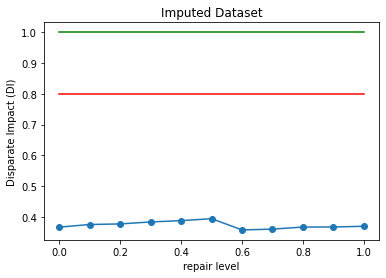

In [13]:
%matplotlib inline
plt.plot(np.linspace(0, 1, 11), DIs1, marker='o')
plt.plot([0, 1], [1, 1], 'g')
plt.plot([0, 1], [0.8, 0.8], 'r')
plt.ylabel('Disparate Impact (DI)')
plt.xlabel('repair level')
plt.title("Imputed Dataset")
plt.show()

In [14]:
DIs2 = run(data_orig_train, data_orig_test)

100%|██████████| 11/11 [01:08<00:00,  6.25s/it]


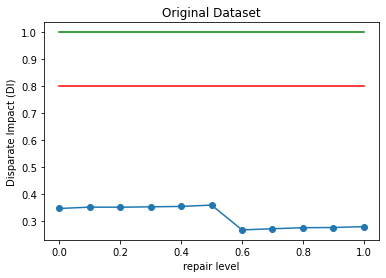

In [15]:
%matplotlib inline
plt.plot(np.linspace(0, 1, 11), DIs2, marker='o')
plt.plot([0, 1], [1, 1], 'g')
plt.plot([0, 1], [0.8, 0.8], 'r')
plt.ylabel('Disparate Impact (DI)')
plt.xlabel('repair level')
plt.title("Original Dataset")
plt.show()

### Try Using Same Preprocessing Steps 

In [18]:
from aif360.datasets import AdultDataset
ad = AdultDataset(protected_attribute_names=['sex'],
    privileged_classes=[['Male']], categorical_features=[],
    features_to_keep=['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week'])
test, train = ad.split([16281])
train.features = scaler.fit_transform(train.features)
test.features = scaler.fit_transform(test.features)

In [19]:
DIs3 = run(train, test)

100%|██████████| 11/11 [00:22<00:00,  2.04s/it]


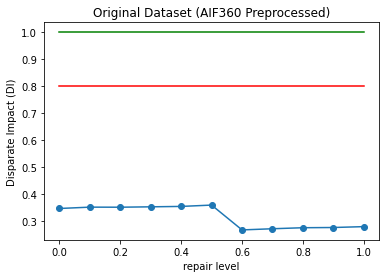

In [20]:
%matplotlib inline
plt.plot(np.linspace(0, 1, 11), DIs2, marker='o')
plt.plot([0, 1], [1, 1], 'g')
plt.plot([0, 1], [0.8, 0.8], 'r')
plt.ylabel('Disparate Impact (DI)')
plt.xlabel('repair level')
plt.title("Original Dataset (AIF360 Preprocessed)")
plt.show()